## Importing Packages

In [1]:
# Importing (using/include) packages and files needed for the code to run 
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics 
using Dates
include("Grid.jl")
include("Markers.jl")
include("Stokes.jl")
include("Temperature.jl")
include("GridOperations.jl")

# Note: that we import pyplot last to avoid a name conflict with grid
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

# Topography Setup

In [2]:
# The initial topography setup follows the following:
# y = A*sin[k(x-b)]+c 
# |A| is the amplitude 
# k is the wave number (k=2π/wavelength)
# The period is 2π/k 
# The horizontal shift is b 
# The vertical shift is c 


function initial_ice_depth(x::Float64)
    w = 90000.0
#     w1 = 90000.0
#     w2 = 10000.0
#     w3 = 100000.0 
#     w4 = 200000.0
#     w5 = 300000.0
#     w6 = 400000.0
#     w7 = 500000.0
    A = 0.1*90000.0
    k = (2*pi)/w
    b = 0.0
    c = 0.5*90000.0
    return (A)*(sin(k*(x-b)))+(c)
end

function initial_surface_depth(x::Float64)
     return 1e4
end

function ice_viscosity(T::Float64)
    Q = 40000.0 # Activation Enegry (J/mol)
    R_cont = 8.314 # Gas Constant (J/mol*K)
    ice_vis = (1e15)*exp((Q*(273.0-T))/(R_cont*(273.0*T)))
    upperlimit = 1e25
    lowerlimit = 1e12
    if ice_vis < lowerlimit
        ice_vis = lowerlimit
    elseif ice_vis > upperlimit
        ice_vis = upperlimit
    else 
        ice_vis = ice_vis
    end 
    return ice_vis
end

ice_viscosity (generic function with 1 method)

# Material Setup

In [25]:
struct Materials
    # 1 - subsurface global ocean
    # 2 - icy shell
    # 3 - sticky air
    alpha::Vector{Float64} # Thermal expansion (1/K)
    rho0::Vector{Float64} # Density (kg/m^3)
    Hr::Vector{Float64} # Radiogenic heat production (W/m^3)
    Cp::Vector{Float64} # Heat capacity (J/kg*K)
    kThermal::Vector{Float64} # Thermal conductivity (W/m*K)
    eta::Vector{Float64} # Viscosity (Pa*s)
    function Materials()
        new([0.0,0.0,0.0],[1000.0,920.0,1.0],[0.0,0.0,0.0],[4180.0,2100.0,1.0e6],[0.5610,2.22,1.0],[1e12,1e15,1e17])
    end    
end

function update_marker_prop!(markers::Markers,materials::Materials)
    eta = markers.scalarFields["eta"]
    rho = markers.scalarFields["rho"]
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark
        markers.scalars[rho,i] = materials.rho0[mmat[i]]
        if mmat[i] == 2
            markers.scalars[eta,i] = ice_viscosity(markers.scalars[T,i])
        end
    end
end

function update_marker_temp!(markers::Markers,materials::Materials)
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark
        if mmat[i] == 1 
            markers.scalars[T,i] = 273.0
        elseif mmat[i] == 3 
            markers.scalars[T,i] = 100.0
        end 
    end 
end 

# function update_marker_viscosity!(markers::Markers,materials::Materials)
#     eta = markers.scalarFields["eta"]
#     T = markers.scalarFields["T"]
#     mmat = markers.integers[markers.integerFields["material"],:]
#     for i in 1:markers.nmark
#         if mmat[i] == 2
#             markers.scalars[eta,i] = ice_viscosity( markers.scalars[T,i] )
#         end
#     end
# end


# function update_marker_density!(markers::Markers,materials::Materials)
#     rho = markers.scalarFields["rho"]
#     T = markers.scalarFields["T"]
#     mmat = markers.integers[markers.integerFields["material"],:]
#     for i in 1:markers.nmark                
#         markers.scalars[rho,i] = materials.rho0[mmat[i]]
#     end
# end

function initial_conditions!(markers::Markers,materials::Materials)
    material = markers.integerFields["material"]
    T = markers.scalarFields["T"]
    eta = markers.scalarFields["eta"]
    alpha = markers.scalarFields["alpha"]
    Cp = markers.scalarFields["Cp"]
    Hr = markers.scalarFields["Hr"]
    
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        hice = initial_ice_depth(mx)
        hsurf = initial_surface_depth(mx)
        if my > hice
            # subsurface global ocean
            markers.integers[material,i] = 1
            markers.scalars[T,i] = 273.0
            markers.scalars[eta,i] = materials.eta[1]
            markers.scalars[alpha,i] = materials.alpha[1]        
            markers.scalars[Cp,i] = materials.Cp[1]
            markers.scalars[Hr,i] = materials.Hr[1]  
        elseif my > hsurf
            # icy shell
            markers.integers[material,i] = 2
            markers.scalars[T,i] = 100.0+((273.0-100.0)/(hice-hsurf))*(my-hsurf)
            # markers.scalars[eta,i] = eta_i[i]
            markers.scalars[alpha,i] = materials.alpha[2]
            markers.scalars[Cp,i] = materials.Cp[2]
            markers.scalars[Hr,i] = materials.Hr[2]  
        else
            # sticky air
            markers.integers[material,i] = 3
            markers.scalars[T,i] = 100.0            
            markers.scalars[eta,i] = materials.eta[3]
            markers.scalars[alpha,i] = materials.alpha[3]  
            markers.scalars[Cp,i] = materials.Cp[3]
            markers.scalars[Hr,i] = materials.Hr[3] 
        end
    end 
    # end loop over markers
#     update_marker_viscosity!(markers,materials)
#     update_marker_density!(markers,materials)
    update_marker_prop!(markers,materials)
end


function get_i_interface(grid::CartesianGrid,mat,contour_value)
    # Setting up inital model schematic
    i_interface_position = zeros(Float64,grid.nx+1);
    for j in 1:grid.nx+1
        i = 1
        while i <= grid.ny
            if i_mat[i,j] == contour_value
                i_interface_position[j] = grid.yc[j]
                break
            elseif i_mat[i+1,j] < contour_value
                # interface is located within this cell.
                i_interface_position[j] = grid.yc[i] + (grid.yc[i+1]-grid.yc[i])/(i_mat[i+1,j]-i_mat[i,j])*(contour_value-i_mat[i,j])
                break
            end
            i = i+1
        end
    end
    return i_interface_position
end

function get_interface(grid::CartesianGrid,mat,contour_value)
    # Finding interfaces 
    interface_position = zeros(Float64,grid.nx+1);
        for j in 1:grid.nx+1
        i = 1
            while i <= grid.ny
                if mat[i,j] == contour_value
                    interface_position[j] = grid.yc[i]
                    break
                elseif mat[i+1,j] < contour_value
                    # interface is located within this cell.
                    interface_position[j] = grid.yc[i] + (grid.yc[i+1]-grid.yc[i])/(mat[i+1,j]-mat[i,j])*(contour_value-mat[i,j])
                    break
                end
                i = i+1
            end
        end
    return interface_position
end

get_interface (generic function with 1 method)

# Model Setup

Creating Markers...
  0.001754 seconds (21 allocations: 8.616 MiB)
Initial condition...
  0.033609 seconds (437.05 k allocations: 6.879 MiB)
Trying with timestep 1.3198118819269214e9 Seconds
dTmax=0.42178549919454156 dt=4.189878990244195e-5 Myr
Writing visualization file = ice_test2/viz.0000.vtr
Writing visualization file = ice_test2/markers.0000.vtp
  0.000383 seconds (2 allocations: 1.401 MiB)
Finished Step 2 time=1.3198118819269214e9 Seconds
Trying with timestep 1.4829670522814033e9 Seconds
dTmax=0.48912488857966707 dt=4.707831912004455e-5 Myr
Writing visualization file = ice_test2/viz.0001.vtr
Writing visualization file = ice_test2/markers.0001.vtp
  0.000435 seconds (2 allocations: 1.401 MiB)
Finished Step 3 time=2.8027789342083244e9 Seconds
Trying with timestep 1.5620057141801486e9 Seconds
dTmax=0.5267043626890455 dt=4.9587482989845985e-5 Myr
Writing visualization file = ice_test2/viz.0002.vtr
Writing visualization file = ice_test2/markers.0002.vtp
  0.000299 seconds (2 allocatio

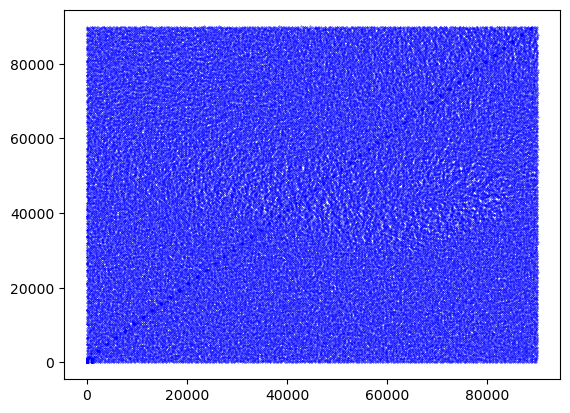

In [32]:

# nstep=10
nx = 51
ny = 52
W = 90000.0
H = 90000.0
gx = 0.0
gy = 1.3


# Tbctype = [-1,-1,1,1] #left, right, top, bottom
Tbctype = [1,-1,1,1]
# Tbcval = [0.0,0.0,100.0,273.0] #left, right, top, bottom
Tbcval = [273.0,0.0,100.0,273.0]
bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.
materials = Materials()

markx = 6
marky = 6
seconds_in_year = 3.15e7
plot_interval = 1e6*seconds_in_year # plot interval in seconds
end_time = 3e7*seconds_in_year
dtmax = plot_interval

grid = CartesianGrid(W,H,nx,ny)
println("Creating Markers...")
@time markers = Markers(grid,["alpha","T","rho","eta","Cp","Hr"],["material"] ; nmx=markx,nmy=marky,random=true)
println("Initial condition...")
@time initial_conditions!(markers, materials)

### Setting up agruments for interface function ###
# initial 
i_air_ice_interface = zeros(Float64,grid.nx+1)
i_ocean_ice_interface = zeros(Float64,grid.nx+1)
i_mat, = marker_to_stag(markers,grid,markers.integers[[markers.integerFields["material"]],:],"center")
i_air_ice_interface = get_i_interface(grid,i_mat,2.5);
i_ocean_ice_interface = get_i_interface(grid,i_mat,1.5);
# after 
air_ice_interface = zeros(Float64,grid.nx+1);
ocean_ice_interface = zeros(Float64,grid.nx+1);
mat, = marker_to_stag(markers,grid,markers.integers[[markers.integerFields["material"]],:],"center")

### Setting up agruments for termination criteria ###
max_step::Int64=100
max_time::Float64=-1.0
max_time::Float64 = max_time == -1.0 ? typemax(Float64) : max_time
max_step::Int64 = max_step == -1 ? typemax(Int64) : max_step

# define arrays for k, rho, cp, H at the basic nodes. Fill them with constant values for now.
kThermal = 3.0 .*ones(grid.ny,grid.nx);

time = 0.0
iout= 0
last_plot = 0.0
dt = 1e10

rho_c = nothing
rho_vx = nothing 
rho_vy = nothing 
alpha = nothing 
Hr = nothing 
Cp_c = nothing 
eta_s = nothing 
eta_n = nothing 
vxc = nothing 
vyc = nothing 
T = nothing 
dTmax = nothing 
dTemp = nothing 
Tnew = nothing 
Tlast = nothing 
x_time = nothing

itime = 1
output_dir = "ice_test2"

terminate = false
while !terminate
    # 0. update the markers properties
    update_marker_prop!(markers,materials)
    update_marker_temp!(markers,materials)
    # 1. Transfer properties markers -> nodes
    # 1a. Basic Nodes
    eta_s_new, = marker_to_stag(markers,grid,["eta",],"basic")
    # 1b. Cell Centers
    rho_c_new,Cp_c_new,alpha_new,eta_n_new,Tlast_new,Hr_new = marker_to_stag(markers,grid,["rho","Cp","alpha","eta","T","Hr"],"center")
    # 1c. Vx and Vy nodes:
    rho_vx_new, = marker_to_stag(markers,grid,["rho",],"vx")
    rho_vy_new, = marker_to_stag(markers,grid,["rho",],"vy") 

    # deal with any NaN values from interpolation:
    if itime > 1
        if any(isnan.(eta_s_new))
            println("found nan values")
        end
        replace_nan!(eta_s,eta_s_new)
        replace_nan!(rho_c,rho_c_new)
        replace_nan!(Hr,Hr_new)
        replace_nan!(Cp_c,Cp_c_new)
        replace_nan!(alpha,alpha_new)
        replace_nan!(eta_n,eta_n_new)
        replace_nan!(Tlast,Tlast_new)
        replace_nan!(rho_vx,rho_vx_new)
        replace_nan!(rho_vy,rho_vy_new)
    end
    # Copy field data 
    rho_vx = copy(rho_vx_new)
    rho_vy = copy(rho_vy_new)
    rho_c = copy(rho_c_new)
    Hr = copy(Hr_new)
    Cp_c = copy(Cp_c_new)
    alpha = copy(alpha_new)
    eta_s = copy(eta_s_new)
    eta_n = copy(eta_n_new)
    Tlast = copy(Tlast_new)
    
    if itime == 1
       ghost_temperature_center(grid,Tlast,Tbctype,Tbcval)
       cell_center_to_markers!(markers,grid,Tlast,markers.scalars[[markers.scalarFields["T"],],:]) 
    else
       #ghost_temperature_center(grid,Tlast,Tbctype,Tbcval)
    end

   
    # 2. Assemble and solve the stokes equations
    L,R = form_stokes(grid,eta_s,eta_n,rho_vx,rho_vy,bc,gx,gy;dt=dt)
    stokes_solution = L\R
    vx,vy,P = unpack(stokes_solution,grid;ghost=true)

    # Get the velocity at the cell centers:
    vxc,vyc = velocity_to_centers(grid,vx,vy)
    adiabatic_heating = compute_adiabatic_heating(grid,rho_c,Tlast,alpha,gx,gy,vxc,vyc)
    shear_heating = compute_shear_heating(grid,vx,vy,eta_n,eta_s)    
    H = (adiabatic_heating .+ shear_heating .+ Hr).*0.0
    
    # 3. Compute the advection timestep
    if itime > 1
        this_dtmax = min(1.2*dt,dtmax)
    else
        this_dtmax = dtmax
    end
    dt = compute_timestep(grid,vxc,vyc ; dtmax=this_dtmax,cfl=0.25)
    diffusion_timestep = (grid.x[2]-grid.x[1])^2 / 1e-6
    if dt > diffusion_timestep
        dt = diffusion_timestep
    end
    
    dTmax = Inf
    dTemp = nothing
    Tnew = nothing
    titer = 1
    for titer=1:2
        # assemble and solve the energy equation
#         println("Trying with timestep ",dt/3.15e7/1e6," Myr")
        println("Trying with timestep ",dt," Seconds")
        L,R = assemble_energy_equation_center(grid,rho_c,Cp_c,kThermal,H,Tlast,dt,Tbctype,Tbcval)
        Tnew = L\R;
        Tnew = reshape(Tnew,grid.ny,grid.nx);
        Tnew = ghost_temperature_center(grid,Tnew,Tbctype,Tbcval);
        T = copy(Tnew)
        dTemp = Tnew-Tlast
        # compute the maximum temperature change
        dTmax = maximum(abs.(dTemp[2:end-1,2:end-1]))           
        println("dTmax=",dTmax," dt=",dt/3.15e7/1e6," Myr")
        dt = min(dt,dTmax < 10.0 ? dt : dt*10.0/dTmax)
        if dTmax < 10.0
            break
        end
    end

    
    
    dT_subgrid_node = subgrid_temperature_relaxation_center!(markers,grid,Tlast,Cp_c[1,1],kThermal[1,1],dt)
    dT_remaining = dTemp - dT_subgrid_node
    
    cell_center_change_to_markers!(markers,grid,dT_remaining,"T")

    
    # Checking Termination Criteria, time is in Myr
    if time >= max_time || itime >= max_step
        terminate = true
    end    

#     if time == 0.0 || time - last_plot >= plot_interval  || mod(itime,100) == 0
#         last_plot = time 
#         name = @sprintf("%s/viz.%04d.vtr",output_dir,iout)
#         vn = velocity_to_basic_nodes(grid,vxc,vyc)
#         visualization(grid,rho_c,eta_s,vn,P,Tnew[2:end-1,2:end-1],time/seconds_in_year;filename=name)
#         name = @sprintf("%s/markers.%04d.vtp",output_dir,iout)
#         visualization(markers,time/seconds_in_year;filename=name)
#         iout += 1
#     end
    
    if time == 0.0 || mod(itime,100) == 0 || true
        last_plot = time 
        # Gird output
        name1 = @sprintf("%s/viz.%04d.vtr",output_dir,iout)
        println("Writing visualization file = ",name1)
        vn = velocity_to_basic_nodes(grid,vxc,vyc)
        visualization(grid,rho_c,eta_s,vn,P,Tnew[2:end-1,2:end-1],time/seconds_in_year;filename=name1)
        # Markers output
        name2 = @sprintf("%s/markers.%04d.vtp",output_dir,iout)
        println("Writing visualization file = ",name2)
        visualization(markers,time/seconds_in_year;filename=name2)
        iout += 1
    end

    # println("Min/Max velocity: ",minimum(vyc)," ",maximum(vyc))            
    # Moving the markers and advancing to the next timestep
    move_markers_rk4!(markers,grid,vx,vy,dt,continuity_weight=1/3)
    time += dt
    itime += 1
    # println("Finished Step ",itime," time=",time/seconds_in_year/1e6," Myr")
    println("Finished Step ",itime," time=",time," Seconds")
    x_time = @sprintf("%.3g",time/3.15e7/1e6);
    ocean_ice_interface = get_interface(grid,mat,1.5);
    air_ice_interface = get_interface(grid,mat,2.5);
end
return grid,markers,vxc,vyc,rho_c,eta_n,Tnew,time,x_time,ocean_ice_interface,air_ice_interface,mat,

figure()
scatter(markers.x[1,:],markers.x[2,:],c="b",s=0.1)
show()

# Plotting Routine 

In [27]:
# # Setting up route for saving plots to a folder
# function mk_output_dir()
#     timestamp = Dates.format(now(), "YYYYmmdd-HHMMSS")
#     dir_name = joinpath(@__DIR__, "Data", "run_$timestamp")
#     @assert !ispath(dir_name) 
#     mkpath(dir_name)
#     return dir_name
# end
maximum(Tnew)

473.9683242204676

# Initial Model Schematic and Profiles

The maximum total initial thickness of the icy shell is 44(km)
The average initial thickness of the icy shell is 34.9(km)
The initial amplitude is 9.16(km)

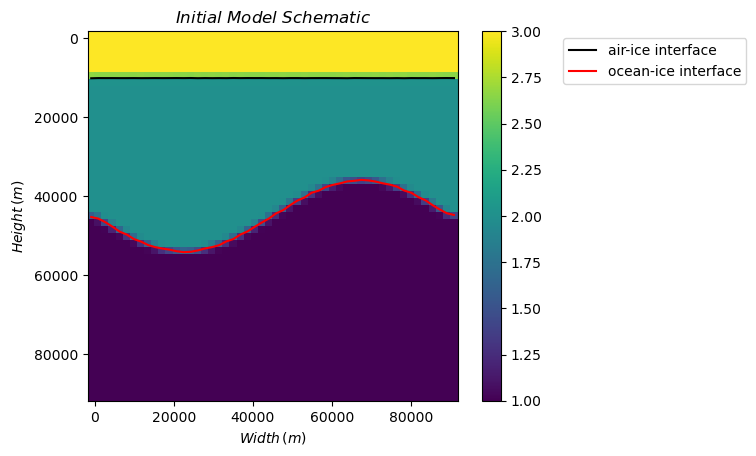

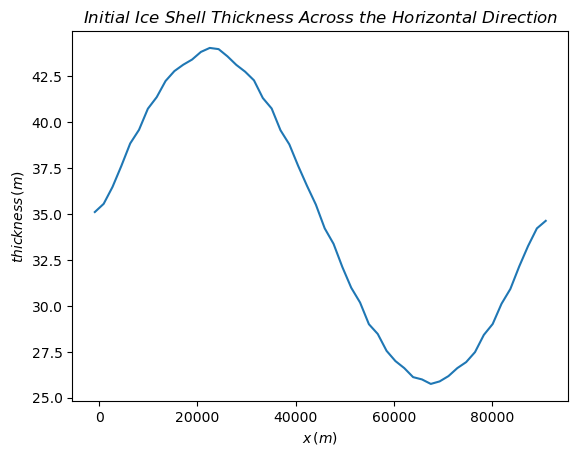

In [28]:
figure() 
pcolor(grid.xc,grid.yc,i_mat)
colorbar()
plot(grid.xc,i_air_ice_interface,"k",label="air-ice interface")
plot(grid.xc,i_ocean_ice_interface,"r",label="ocean-ice interface")
title(L"Initial\,\,Model\,\,Schematic")
# filename = "Initial Model Schematic"
gca().invert_yaxis()
gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(m)")
gca().set_xlabel(L"Width\,(m)")
legend(loc="upper right",bbox_to_anchor=[1.8,1.0])
# savefig(mk_output_dir()*"/$filename.pdf")

figure() 
plot(grid.xc,(i_ocean_ice_interface-i_air_ice_interface)/1000)
title(L"Initial\,\,Ice\,\,Shell\,\,Thickness\,\,Across\,\,the\,\,Horizontal\,\,Direction")
gca().set_ylabel(L"thickness\,(m)")
gca().set_xlabel(L"x\,(m)")


println("The maximum total initial thickness of the icy shell is ",@sprintf("%.3g",maximum(i_ocean_ice_interface-i_air_ice_interface)/1000),"(km)")
i_ice_avg = mean(i_ocean_ice_interface-i_air_ice_interface)
println("The average initial thickness of the icy shell is ",@sprintf("%.3g",i_ice_avg/1000),"(km)")
i_amp = (maximum(i_ocean_ice_interface-i_air_ice_interface)-i_ice_avg)
print("The initial amplitude is ",@sprintf("%.3g",i_amp/1000),"(km)")



# Model Schematic After x Runs 

The maximum total thickness of the icy shell after 0.00899 Myr is 38.7(km)
The average thickness of the icy shell after 0.00899 Myr is 35(km)
The amplitude after 0.00899 Myr is 3.62(km)

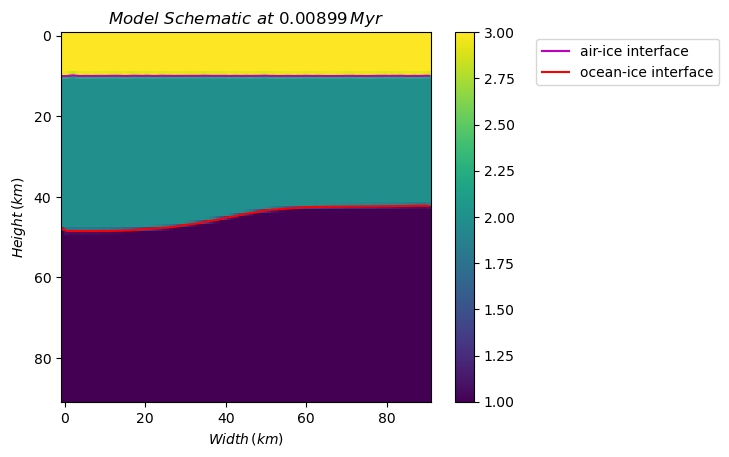

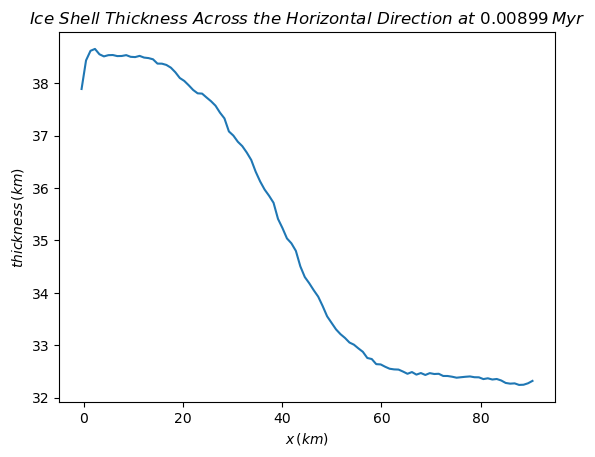

In [37]:
# filename = "Model Schematic after $time"
figure()
pcolor(grid.xc/1000,grid.yc/1000,mat)
colorbar()
plot(grid.xc/1000,air_ice_interface/1000,"m",label="air-ice interface")
plot(grid.xc/1000,ocean_ice_interface/1000,"r",label="ocean-ice interface")
title(L"Model\,\,Schematic\,\,at\,\,%$x_time\,Myr")
gca().invert_yaxis()
gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(km)")
gca().set_xlabel(L"Width\,(km)")
legend(loc="upper right",bbox_to_anchor=[1.8,1.0])
show()

figure()
plot(grid.xc/1000,(ocean_ice_interface-air_ice_interface)/1000)
title(L"Ice\,\,Shell\,\,Thickness\,\,Across\,\,the\,\,Horizontal\,\,Direction\,\,at\,\,%$x_time\,Myr")
gca().set_ylabel(L"thickness\,(km)")
gca().set_xlabel(L"x\,(km)")
show()

println("The maximum total thickness of the icy shell after $x_time Myr is ",@sprintf("%.3g",maximum(ocean_ice_interface-air_ice_interface)/1000),"(km)")
ice_avg = mean(ocean_ice_interface-air_ice_interface)
println("The average thickness of the icy shell after $x_time Myr is ",@sprintf("%.3g",ice_avg/1000),"(km)")
amp = (maximum(ocean_ice_interface-air_ice_interface)-ice_avg)
print("The amplitude after $x_time Myr is ",@sprintf("%.3g",amp/1000),"(km)")

# Plot of Profiles After x Runs

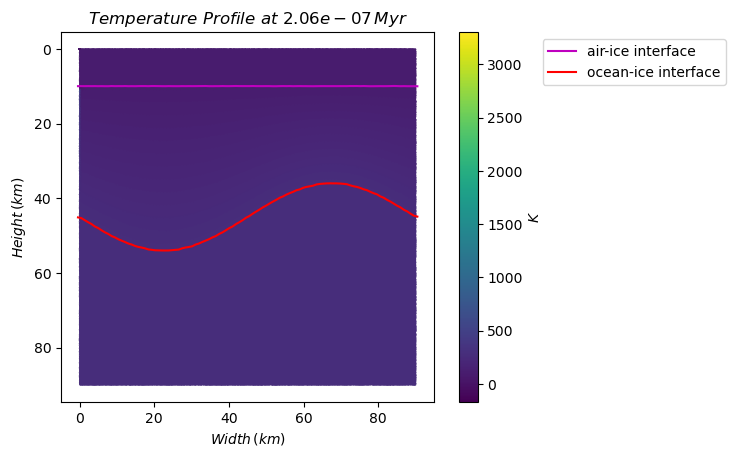

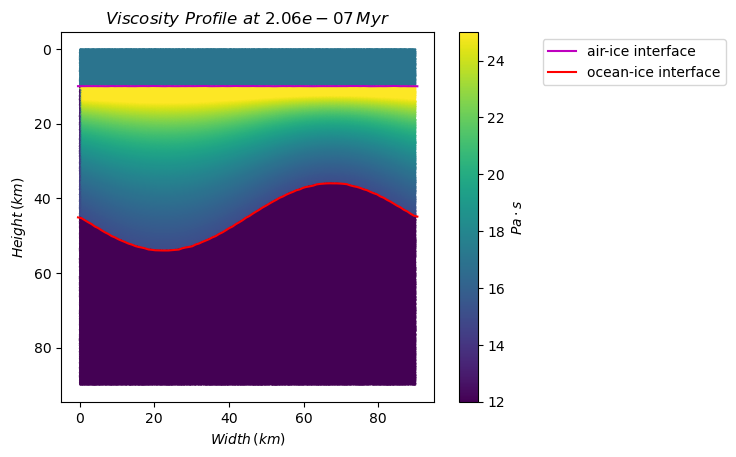

In [12]:
# Temperature Profile 
x_time = @sprintf("%.3g",time/3.15e7/1e6)
figure()
scatter(markers.x[1,:]/1000,markers.x[2,:]/1000,c=markers.scalars[markers.scalarFields["T"],:],s=0.1)
plot(grid.xc/1000,air_ice_interface/1000,"m",label="air-ice interface")
plot(grid.xc/1000,ocean_ice_interface/1000,"r",label="ocean-ice interface")
title(L"Temperature\,\,Profile\,\,at\,\,%$x_time\,Myr")
colorbar(label=L"K")
gca().invert_yaxis()
gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(km)")
gca().set_xlabel(L"Width\,(km)")
legend(loc="upper right",bbox_to_anchor=[1.8,1.0])
show()

# Viscosity Profile 
figure()
scatter(markers.x[1,:]/1000,markers.x[2,:]/1000,c=log10.(markers.scalars[markers.scalarFields["eta"],:]),s=0.1)
plot(grid.xc/1000,air_ice_interface/1000,"m",label="air-ice interface")
plot(grid.xc/1000,ocean_ice_interface/1000,"r",label="ocean-ice interface")
title(L"Viscosity\,\,Profile\,\,at\,\,%$x_time\,Myr")
colorbar(label=L"Pa\cdot{s}")
gca().invert_yaxis()
gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(km)")
gca().set_xlabel(L"Width\,(km)")
legend(loc="upper right",bbox_to_anchor=[1.8,1.0])
show()


In [ ]:
t = time/3.15e7/1e6 # Myr
tr = -(t)/log(amp/i_amp)
print(@sprintf("%.3g",tr),"(Myr)")


In [ ]:
# 1. Ran numerical experiments for 30 timesteps at nx = 101 and ny = 101 and wavelengths were 90km,10km,100km,200km,300km 
# 2. Ran numerical experiments for 30 timesteps at nx = 201 and ny = 201 and wavelengths were 10km, 15km, 30km, 45km, 60km
#[experiment_1,experiment_2,experiment_3,experiment_4,experiment_5]

# 1.
# units of Myr
exp1_x_tr1 = 0.00721
exp1_x_tr2 = 0.0267
exp1_x_tr3 = 0.0277
exp1_x_tr4 = 0.0533
exp1_x_tr5 = 0.0581
exp1_x_tr6 = 0.0715
exp1_x_tr7 = 0.0885


# units of km 
exp1_y_w1 = 10
exp1_y_w2 = 90
exp1_y_w3 = 100
exp1_y_w4 = 200
exp1_y_w5 = 300
exp1_y_w6 = 400
exp1_y_w7 = 500

figure()
plot(exp1_x_tr1,exp1_y_w1,"o",label=L"\lambda\,=\,90\,(km)")
plot(exp1_x_tr2,exp1_y_w2,"o",label=L"\lambda\,=\,10\,(km)")
plot(exp1_x_tr3,exp1_y_w3,"o",label=L"\lambda\,=\,100\,(km)")
plot(exp1_x_tr4,exp1_y_w4,"o",label=L"\lambda\,=\,200\,(km)")
plot(exp1_x_tr5,exp1_y_w5,"o",label=L"\lambda\,=\,300\,(km)")
plot(exp1_x_tr6,exp1_y_w6,"o",label=L"\lambda\,=\,400\,(km)")
plot(exp1_x_tr7,exp1_y_w7,"o",label=L"\lambda\,=\,500\,(km)")
gca().set_ylabel(L"\lambda\,(km)")
gca().set_xlabel(L"time\,(Myr)")
title(L"Relaxation\,\,Timescale\,\,vs.\,\,Initital\,\,Topographic\,\,Wavelength\,\,Experiment\,1")
legend(loc="upper right",bbox_to_anchor=[1.8,1.0])
show()


# 2. 
# units of Myr 
exp2_x_tr1 = 0.00939
exp2_x_tr2 = 0.0127
exp2_x_tr3 = 0.013
exp2_x_tr4 = 0.0195
exp2_x_tr5 = 0.0256
exp2_x_tr6 = 0.0323
exp2_x_tr7 = 0.04

# units of km 
exp2_y_w1 = 10
exp2_y_w2 = 90
exp2_y_w3 = 100
exp2_y_w4 = 200
exp2_y_w5 = 300
exp2_y_w6 = 400
exp2_y_w7 = 500

figure()
plot(exp2_x_tr1,exp2_y_w1,"o",label=L"\lambda\,=\,10\,(km)")
plot(exp2_x_tr2,exp2_y_w2,"o",label=L"\lambda\,=\,90\,(km)")
plot(exp2_x_tr3,exp2_y_w3,"o",label=L"\lambda\,=\,100\,(km)")
plot(exp2_x_tr4,exp2_y_w4,"o",label=L"\lambda\,=\,200\,(km)")
plot(exp2_x_tr5,exp2_y_w5,"o",label=L"\lambda\,=\,300\,(km)")
plot(exp2_x_tr6,exp2_y_w6,"o",label=L"\lambda\,=\,400\,(km)")
plot(exp2_x_tr7,exp2_y_w7,"o",label=L"\lambda\,=\,500\,(km)")
gca().set_ylabel(L"\lambda\,(km)")
gca().set_xlabel(L"time\,(Myr)")
title(L"Relaxation\,\,Timescale\,\,vs.\,\,Initital\,\,Topographic\,\,Wavelength\,\,Experiment\,2")
legend(loc="upper right",bbox_to_anchor=[1.8,1.0])
show()

# Printing Values 

In [ ]:
# print("Creating eta at cell center matrix...")
# @time display(eta_n)
# print("Creating vx matrix...")
# @time display(vxc)
# print("Creating vy matrix...")
# @time display(vyc)
# print("Creating rho matrix...")
# @time display(rho_c)